In [1]:
!wget http://nlp.stanford.edu/data/glove.6B.zip


--2026-02-11 06:12:30--  http://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.6B.zip [following]
--2026-02-11 06:12:30--  https://nlp.stanford.edu/data/glove.6B.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2026-02-11 06:12:30--  https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip’

glov

In [2]:
!unzip glove.6B.zip


Archive:  glove.6B.zip
  inflating: glove.6B.50d.txt        
  inflating: glove.6B.100d.txt       
  inflating: glove.6B.200d.txt       
  inflating: glove.6B.300d.txt       


In [5]:
import numpy as np
import pandas as pd
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt


In [6]:
glove_file = "glove.6B.100d.txt"

embeddings = {}

with open(glove_file, "r", encoding="utf-8") as f:
    for line in f:
        values = line.split()
        word = values[0]
        vector = np.array(values[1:], dtype="float32")
        embeddings[word] = vector

print("Vocabulary Size:", len(embeddings))
print("Vector size:", len(embeddings["king"]))
print("Example vector for 'king' (first 10 values):", embeddings["king"][:10])


Vocabulary Size: 400000
Vector size: 100
Example vector for 'king' (first 10 values): [-0.32307 -0.87616  0.21977  0.25268  0.22976  0.7388  -0.37954 -0.35307
 -0.84369 -1.1113 ]


In [7]:
def cosine_similarity(vec1, vec2):
    return np.dot(vec1, vec2) / (np.linalg.norm(vec1) * np.linalg.norm(vec2))


In [9]:
# STEP 4: Similarity for at least 10 word pairs

pairs = [
    ("doctor", "nurse"),
    ("cat", "dog"),
    ("car", "bus"),
    ("king", "queen"),
    ("man", "woman"),
    ("apple", "banana"),
    ("teacher", "student"),
    ("india", "pakistan"),
    ("computer", "laptop"),
    ("happy", "sad")
]

results = []

for w1, w2 in pairs:
    if w1 in embeddings and w2 in embeddings:
        sim = cosine_similarity(embeddings[w1], embeddings[w2])
    else:
        sim = np.nan # Assign NaN if one or both words are not found
    results.append([w1, w2, sim])

df_similarity = pd.DataFrame(results, columns=["Word1", "Word2", "Similarity"])
df_similarity

,Word1,Word2,Similarity
0,doctor,nurse,0.752151
1,cat,dog,0.879808
2,car,bus,0.737271
3,king,queen,0.750769
4,man,woman,0.832349
5,apple,banana,0.505447
6,teacher,student,0.808340
7,india,pakistan,0.837032
8,computer,laptop,0.702416
9,happy,sad,0.680114


In [11]:
# STEP 5: Nearest neighbors for chosen words

def find_nearest_neighbors(word, embeddings, topn=10):
    if word not in embeddings:
        return [] # Return empty list if word not in vocabulary

    word_vector = embeddings[word]
    similarities = []

    for other_word, other_vector in embeddings.items():
        if other_word == word:
            continue # Skip the word itself
        sim = cosine_similarity(word_vector, other_vector)
        similarities.append((other_word, sim))

    # Sort by similarity in descending order and return topn
    similarities.sort(key=lambda x: x[1], reverse=True)
    return similarities[:topn]

chosen_words = ["king", "university", "doctor", "india", "computer"]

for word in chosen_words:
    print(f"\nTop similar words to '{word}':")
    nearest_neighbors = find_nearest_neighbors(word, embeddings, topn=10)
    if nearest_neighbors:
        for similar_word, score in nearest_neighbors:
            print(similar_word, "->", score)
    else:
        print(f"Word '{word}' not found in embeddings.")


Top similar words to 'king':
prince -> 0.7682328
queen -> 0.750769
son -> 0.70208883
brother -> 0.6985776
monarch -> 0.697789
throne -> 0.6919991
kingdom -> 0.68114096
father -> 0.6802029
emperor -> 0.67128575
ii -> 0.6676074

Top similar words to 'university':
college -> 0.8294213
harvard -> 0.8156034
yale -> 0.8113802
professor -> 0.81037843
graduate -> 0.79930013
faculty -> 0.77934235
princeton -> 0.7627182
institute -> 0.7604439
school -> 0.7548451
stanford -> 0.7424826

Top similar words to 'doctor':
physician -> 0.76732415
nurse -> 0.75215083
dr. -> 0.71751934
doctors -> 0.7080885
patient -> 0.7074183
medical -> 0.6995992
surgeon -> 0.69053394
hospital -> 0.69009304
psychiatrist -> 0.6589098
dentist -> 0.6447421

Top similar words to 'india':
pakistan -> 0.8370324
indian -> 0.7802031
delhi -> 0.77121943
bangladesh -> 0.76616395
lanka -> 0.7639287
sri -> 0.75065845
australia -> 0.70420957
malaysia -> 0.6796302
nepal -> 0.6761943
thailand -> 0.6671633

Top similar words to 'comput

In [13]:
# STEP 6: Word analogy tasks

def solve_analogy(positive_words, negative_words, embeddings, topn=5):
    analogy_vector = np.zeros(list(embeddings.values())[0].shape)

    for word in positive_words:
        if word in embeddings:
            analogy_vector += embeddings[word]
        else:
            return [] # Handle case where a word is not found

    for word in negative_words:
        if word in embeddings:
            analogy_vector -= embeddings[word]
        else:
            return [] # Handle case where a word is not found

    similarities = []
    # Exclude input words from the results
    exclude_words = set(positive_words + negative_words)

    for word, vector in embeddings.items():
        if word not in exclude_words:
            sim = cosine_similarity(analogy_vector, vector)
            similarities.append((word, sim))

    similarities.sort(key=lambda x: x[1], reverse=True)
    return similarities[:topn]

analogies = [
    (["king", "woman"], ["man"]),         # king - man + woman
    (["paris", "india"], ["france"]),      # paris - france + india
    (["teacher", "hospital"], ["school"]) # teacher - school + hospital
]

for positive, negative in analogies:
    print("\nAnalogy:")
    print("Positive:", positive)
    print("Negative:", negative)

    result = solve_analogy(positive, negative, embeddings, topn=5)
    if result:
        print("Top results:")
        for word, score in result:
            print(word, "->", score)
    else:
        print("Could not complete analogy due to missing word(s).")


Analogy:
Positive: ['king', 'woman']
Negative: ['man']
Top results:
queen -> 0.7834413916974592
monarch -> 0.6933802209538377
throne -> 0.6833110473268437
daughter -> 0.6809082968161031
prince -> 0.6713142533039991

Analogy:
Positive: ['paris', 'india']
Negative: ['france']
Top results:
delhi -> 0.8632235739218902
mumbai -> 0.7723553768088395
bombay -> 0.7235930562237989
dhaka -> 0.6914991035823776
lahore -> 0.6785182999398838

Analogy:
Positive: ['teacher', 'hospital']
Negative: ['school']
Top results:
nurse -> 0.7524442060016792
doctor -> 0.7353193945954121
patient -> 0.6864996297020909
hospitalized -> 0.6858999542245082
physician -> 0.6614402976600849


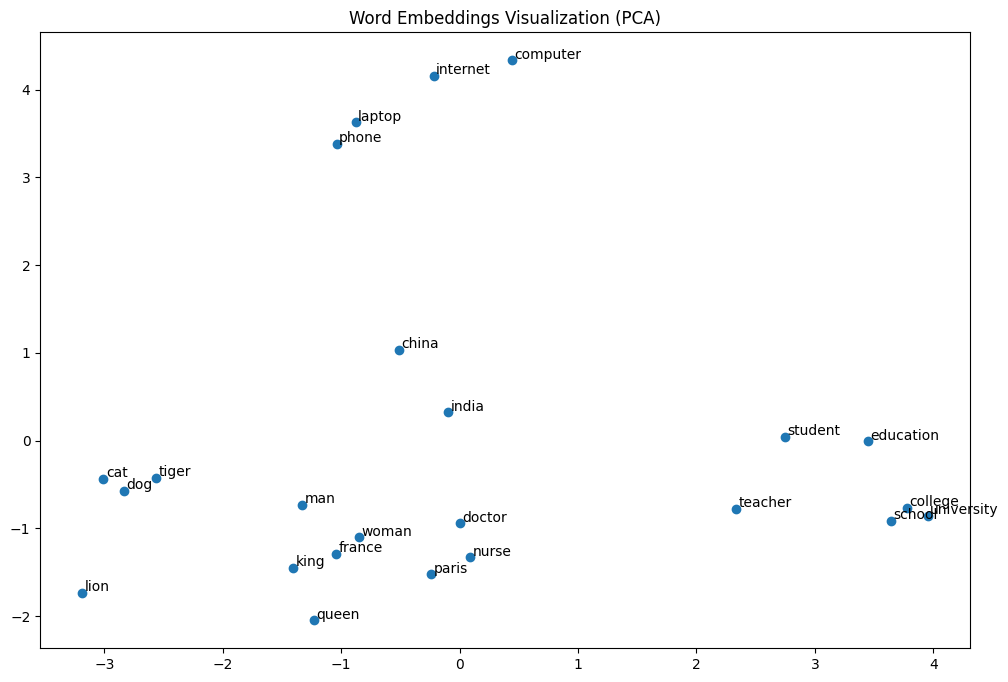

In [15]:
# STEP 7: Visualization using PCA

plot_words = [
    "king", "queen", "man", "woman",
    "doctor", "nurse", "teacher", "student",
    "india", "china", "france", "paris",
    "cat", "dog", "lion", "tiger",
    "computer", "laptop", "phone", "internet",
    "university", "college", "school", "education"
]

vectors = np.array([embeddings[w] for w in plot_words])

# Reduce 100D to 2D using PCA
pca = PCA(n_components=2)
reduced = pca.fit_transform(vectors)

plt.figure(figsize=(12, 8))
plt.scatter(reduced[:, 0], reduced[:, 1])

for i, word in enumerate(plot_words):
    plt.text(reduced[i, 0] + 0.02, reduced[i, 1] + 0.02, word)

plt.title("Word Embeddings Visualization (PCA)")
plt.show()